In [1]:
# Check jupyter or not
from IPython import get_ipython
def type_of_script():
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str: return 'jupyter'
        if 'terminal' in ipy_str: return 'ipython'
    except: return 'terminal'
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm

# Default libraries
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as patheffects
from matplotlib import colormaps
from matplotlib.colors import Normalize
import cmasher as cmr
import numpy as np
import os, glob, atexit, signal, time, warnings
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value
from scipy.optimize import curve_fit

# rur package
from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0

# Custom package
from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from common_func import *
from ramses_function import *

# Python Argument Parser
# print("ex: $ python3 06c_stable_tree.py [--mod 7]")
# import argparse
# parser = argparse.ArgumentParser(description='(syj3514@yonsei.ac.kr)')
# parser.add_argument("-m", "--mod", required=True, help='mod', type=int)
# args = parser.parse_args()
# mod = args.mod

In [2]:
ncpu=48
home = '/home/jeon'
if(not os.path.isdir(home)): home = '/gem_home/jeon'

In [3]:
mode1 = 'nh'; database1 = f"{home}/MissingSat/database/{mode1}"
iout1 = 1026; repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1); snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
# gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
# hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1, allsubs1, states1, dinks1, pairs1, upairs1 = extract_from_LG(LG1)
print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [4]:
mode2 = 'nh2'; database2 = f"{home}/MissingSat/database/{mode2}"
iout2 = 797; repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2); snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
# gals1 = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
# hals1 = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

LG2 = pklload(f"{database2}/LocalGroup.pickle")
allsats2, allsubs2, states2, dinks2, pairs2, upairs2 = extract_from_LG(LG2)
print(len(allsubs2), np.unique(states2, return_counts=True))  

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


In [5]:
stree1 = pklload(f"{database1}/stable_tree_new.pickle")
rtree1 = pklload(f"{database1}/stable_tree_raw.pickle")
print(stree1[list(stree1.keys())[0]].dtype.names)
stree2 = pklload(f"{database2}/stable_tree_new.pickle")
rtree2 = pklload(f"{database2}/stable_tree_raw.pickle")

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'mcontam', 'r10_mem', 'r50_mem', 'r90_mem', 'r10_vir', 'r50_vir', 'r90_vir', 'r10_max', 'r50_max', 'r90_max', 'sub', 'dink', 'mdm', 'mstar', 'mcold', 'mcell', 'Host', 'r200kpc', 'm200', 'r200', 'mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', 'lastid', 'give_score', 'take_score', 'insitu', 'insitu_vir')


In [6]:
cases1 = pklload(f"{database1}/case_dict.pickle")
cases2 = pklload(f"{database2}/case_dict.pickle")

In [7]:
str1, str2, ids = cases1['p'][6]
print(str1, str2, ids)

Has star No SF [24361 24509 24877 25250 25284]


In [8]:
boundary = 5
drawmodes = 0
# 0: full
# 1: during star having period
# 2: during SF period

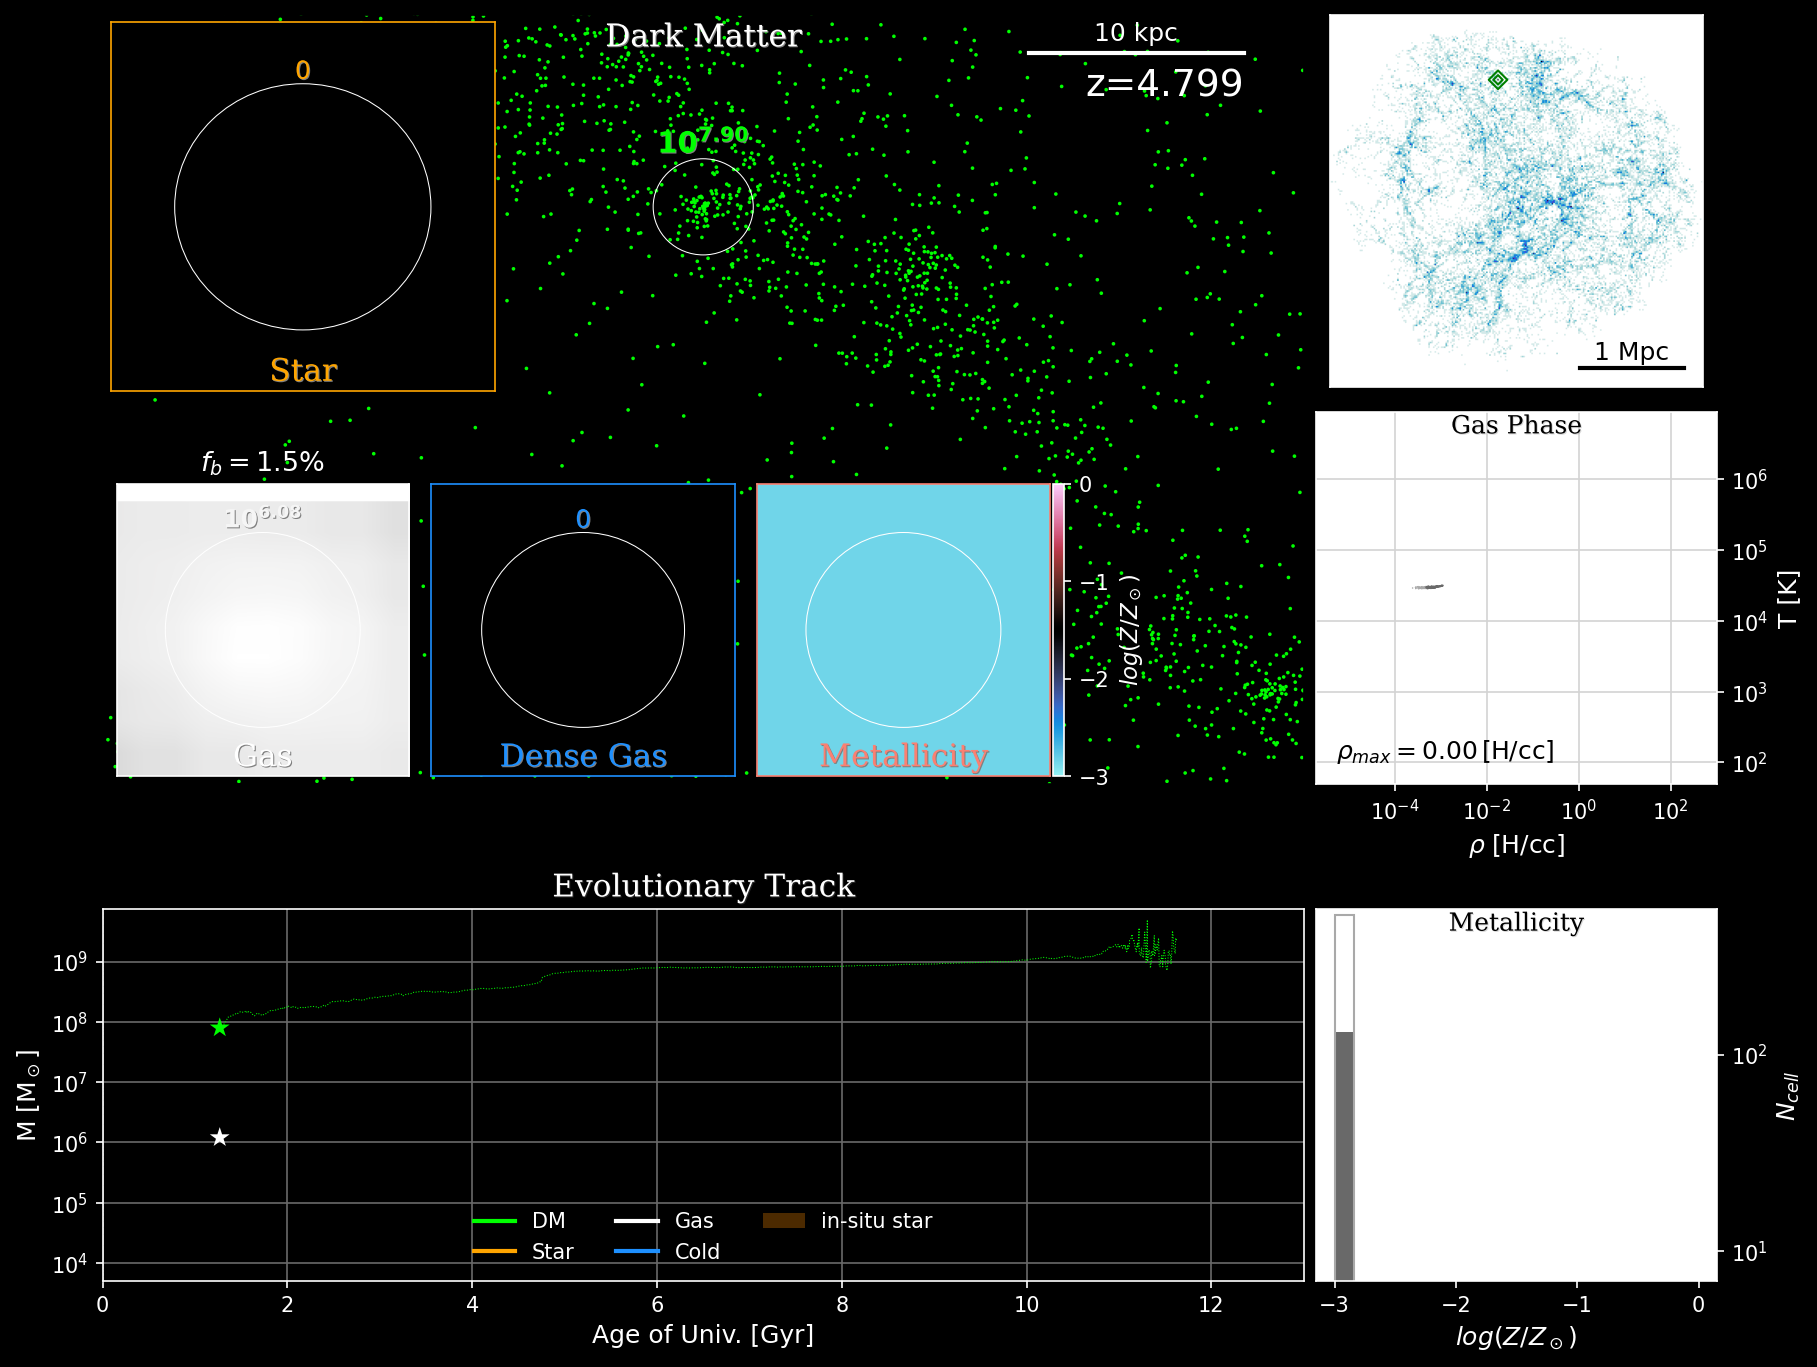

24361: 0087 done


ValueError: stop!

In [27]:
targetid = ids[0]
branch = stree1[targetid]
zoom = 1.5
dpi = 240
nmax = dpi**2 / 2
count = 0

if(drawmodes==0):
    imin = 0; imax=10000
elif(drawmodes==1):
    havestar = np.where(branch['mstar_vir']>0)[0]
    imax = branch['timestep'][max(0, havestar[0]-boundary)]
    imin = branch['timestep'][min( havestar[-1]+boundary, len(branch)-1)]
elif(drawmodes==2):
    havestar = np.where(branch['insitu_vir']>0)[0]
    imax = branch['timestep'][max(0, havestar[0]-boundary)]
    imin = branch['timestep'][min( havestar[-1]+boundary, len(branch)-1)]
else:
    raise ValueError("drawmodes should be 0, 1, or 2")

for iout in branch['timestep'][::-1]:
    if(iout>imax)or(iout<imin): continue
    isnap = snap1s.get_snap(iout)
    
    fig = plt.figure(figsize=(12,9), layout="constrained", dpi=150, facecolor='k')
    gs = gridspec.GridSpec(3, 4, figure=fig)

    ###### DM Map
    # Data Process
    isnap = snap1s.get_snap(iout)
    target = branch[branch['timestep'] == iout][0]
    iarg = np.where(branch['timestep'] == iout)[0][0]
    isnap.set_box_halo(target, zoom*6)
    extent = isnap.box[:2].flatten()
    xbins = np.linspace(extent[0], extent[1], int(dpi*2)); ybins = np.linspace(extent[2], extent[3], int(dpi*2))
    part = isnap.get_part(target_fields=['x','y','z','id','epoch','m'])
    dm = part['dm']
    indm = cut_sphere(dm, target['x'], target['y'], target['z'], target['rvir'])
    # Drawing
    ax_dm = fig.add_subplot(gs[0:2, 0:3], facecolor='k', xticks=[], yticks=[])
    if(len(dm)>nmax):
        hist, xe, ye = np.histogram2d(dm['x'], dm['y'], bins=[xbins, ybins], weights=dm['m'])
        dA = (xe[1]-xe[0])*(ye[1]-ye[0]); hist /= dA
        vmax = np.log10(np.max(hist)/2)
        ycen = 0.5*(extent[2]+extent[3]); dy = extent[3]-extent[2]; y1 = extent[2]; y2 = ycen + dy/6
        ax_dm.imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.tree, vmax=vmax, vmin=vmax-3)
    else:
        ax_dm.scatter(dm['x'], dm['y'], s=nmax/len(dm), ec='none', fc='lime', marker=".")
        ycen = 0.5*(extent[2]+extent[3]); dy = extent[3]-extent[2]; y1 = extent[2]; y2 = ycen + dy/6
        ax_dm.set_xlim(extent[0], extent[1])
    ax_dm.set_ylim(y1,y2)
    # Info
    cir = circle(target, rname='rvir'); ax_dm.add_patch(cir)
    tmpstr = fr"$\mathbf{{10^{{{np.log10(np.sum(indm['m','Msol'])):.2f}}}}}$" if len(indm)>0 else "0"
    ax_dm.text(target['x'], target['y']+target['rvir'], tmpstr, color='lime', ha='center', va='bottom', fontsize=14, path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=1)])
    ax_dm.text(0.95, 0.93, f"z={1/isnap.aexp-1:.3f}", color='w', ha='right', va='top', fontsize=18, transform=ax_dm.transAxes)
    ax_dm.text(0.5,0.99, "Dark Matter", color='w', ha='center', va='top', fontsize=15, transform=ax_dm.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=1)])
    add_scalebar(ax_dm, isnap.unit_l, color='w', fontsize=12, top=True)



    ###### Zoom-in
    isnap.set_box_halo(target, zoom)
    extent = isnap.box[:2].flatten()
    xbins = np.linspace(extent[0], extent[1], dpi)
    ybins = np.linspace(extent[2], extent[3], dpi)
    # isnap.set_box_halo(target, zoom*2)
    part = isnap.get_part(target_fields=['x','y','z','id','epoch','m'])
    cell = isnap.get_cell(target_fields=['x','y','z','rho','P','metal'])
    # isnap.set_box_halo(target, zoom)
    buffer = 0.01
    length = 0.5



    ###### Star Map
    # Data Process
    instar = cut_sphere(part['star'], target['x'], target['y'], target['z'], target['rvir'])
    # Drawing
    ax_star = ax_dm.inset_axes([buffer*2/3, 1-length+buffer, (length-buffer*2)*2/3, (length-buffer*2)], xticks=[], yticks=[], facecolor='k')
    for spine in ax_star.spines.values(): spine.set_edgecolor('orange')
    if(len(part['star'])<(nmax/10))and(len(part['star'])>0):
        ax_star.scatter(part['star']['x'], part['star']['y'], s=(nmax/40)/len(part['star']), ec='none', fc='orange',marker="*")
        ax_star.set_xlim(*isnap.box[0]); ax_star.set_ylim(*isnap.box[1])
    elif(len(part['star'])==0):
        ax_star.scatter(part['star']['x'], part['star']['y'], s=0, ec='none', fc='orange',marker="*")
        ax_star.set_xlim(*isnap.box[0]); ax_star.set_ylim(*isnap.box[1])
    else:
        hist, xe, ye = np.histogram2d(part['star']['x'], part['star']['y'], bins=[xbins, ybins], weights=part['star']['m'])
        dA = (xe[1]-xe[0])*(ye[1]-ye[0]); hist /= dA
        vmax = np.log10(np.max(hist)/2)
        ax_star.imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.sunburst, vmax=vmax, vmin=vmax-3)
    # Info
    cir = circle(target, rname='rvir'); ax_star.add_patch(cir)
    tmpstr = fr"$\mathbf{{10^{{{np.log10(np.sum(instar['m','Msol'])):.2f}}}}}$" if len(instar)>0 else "0"
    ax_star.text(target['x'], target['y']+target['rvir'], tmpstr, color='orange', ha='center', va='bottom', fontsize=12, path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=1)])
    ax_star.text(0.5,0.01, "Star", color='orange', ha='center', va='bottom', fontsize=15, transform=ax_star.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=1)])


    length = 0.4
    ###### Gas Map
    # Data Process
    incell = cut_sphere(cell, target['x'], target['y'], target['z'], target['rvir'])
    # Drawing
    ax_gas = ax_dm.inset_axes([buffer*2/3, buffer, (length-buffer*2)*2/3, (length-buffer*2)], xticks=[], yticks=[], facecolor='k')
    for spine in ax_gas.spines.values(): spine.set_edgecolor('white')
    gasmap = painter.gasmap(cell, shape=dpi)
    vmax = np.log10(np.max(gasmap))
    ax_gas.imshow(np.log10(gasmap), origin='lower', extent=extent, cmap=cmr.neutral, vmax=vmax, vmin=vmax-3)
    # Info
    cir = circle(target, rname='rvir'); ax_gas.add_patch(cir)
    tmpstr = fr"$\mathbf{{10^{{{np.log10(np.sum(incell['m','Msol'])):.2f}}}}}$" if len(incell)>0 else "0"
    ax_gas.text(target['x'], target['y']+target['rvir'], tmpstr, color='whitesmoke', ha='center', va='bottom', fontsize=12, path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=1)])
    ax_gas.set_title(fr"$f_b={(np.sum(incell['m'])+np.sum(instar['m']))/(np.sum(instar['m']) + np.sum(indm['m']) + np.sum(incell['m']))*100:.1f}$%", color='w',fontsize=13)
    ax_gas.text(0.5,0.01, "Gas", color='w', ha='center', va='bottom', fontsize=15, transform=ax_gas.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=1)])



    ###### Cold Map
    # Data Process
    # cold = cell[cell['T','K'] < 1e4]
    cold = cell[cell['rho','H/cc'] > 10]
    incold = cut_sphere(cold, target['x'], target['y'], target['z'], target['rvir'])
    # Drawing
    ax_cold = ax_dm.inset_axes([(length+buffer)*2/3, buffer, (length-buffer*2)*2/3, (length-buffer*2)], xticks=[], yticks=[], facecolor='k')
    for spine in ax_cold.spines.values(): spine.set_edgecolor('dodgerblue')
    if(len(cold)>0):
        coldmap = painter.gasmap(cold, shape=dpi)
        vmax = np.log10(np.max(coldmap))
        ax_cold.imshow(np.log10(coldmap), origin='lower', extent=extent, cmap=cmr.arctic, vmax=vmax, vmin=vmax-3)
    else:
        ax_cold.set_xlim(*isnap.box[0]); ax_cold.set_ylim(*isnap.box[1])
    # Info
    cir = circle(target, rname='rvir')
    ax_cold.add_patch(cir)
    tmpstr = fr"$\mathbf{{10^{{{np.log10(np.sum(incold['m','Msol'])):.2f}}}}}$" if len(incold)>0 else "0"
    ax_cold.text(target['x'], target['y']+target['rvir'], tmpstr, color='dodgerblue', ha='center', va='bottom', fontsize=12, path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=1)])
    ax_cold.text(0.5,0.01, "Dense Gas", color='dodgerblue', ha='center', va='bottom', fontsize=15, transform=ax_cold.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=1)])



    ###### Metal Map
    # Data Process
    metalmap = painter.gasmap(cell, mode='metal', shape=dpi)
    metalmap = gaussian_filter(metalmap, int(dpi/70))
    metalmap = np.log10(metalmap/0.0142)
    # Drawing
    ax_metal = ax_dm.inset_axes([(2*length+buffer)*2/3, buffer, (length-buffer*2)*2/3, (length-buffer*2)], xticks=[], yticks=[], facecolor='k')
    for spine in ax_metal.spines.values(): spine.set_edgecolor('salmon')
    metal_cmap = cmr.redshift
    ax_metal.imshow(metalmap, origin='lower', extent=extent, cmap=metal_cmap, vmax=0, vmin=-3)
    # Info
    cir = circle(target, rname='rvir'); ax_metal.add_patch(cir)
    ax_metal.text(0.5,0.01, "Metallicity", color='salmon', ha='center', va='bottom', fontsize=15, transform=ax_metal.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=1)])
    # Colorbar
    cax = ax_metal.inset_axes([1.01, 0.00, 0.04, 1.0])
    norm = Normalize(vmin=-3,vmax=0); sm = plt.cm.ScalarMappable(cmap=metal_cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical', ticks=[-3,-2,-1,0])
    cbar.set_label(r"$log(Z/Z_\odot)$", color='w', fontsize=11)
    cbar.outline.set_edgecolor('w')
    for spine in cax.spines.values(): spine.set_edgecolor('w')
    cax.tick_params(axis='x', colors='w', labelsize=8); cax.tick_params(axis='y', colors='w')



    ###### DM large scale
    sax1 = fig.add_subplot(gs[0,3], xticks=[], yticks=[])
    ihals = uhmi.HaloMaker.load(isnap, galaxy=False)
    ihals = ihals[ihals['mcontam'] < ihals['m']*0.01]
    x1 = np.min(ihals['x']); x2 = np.max(ihals['x']); dx = x2-x1; xc = x1+dx/2
    y1 = np.min(ihals['y']); y2 = np.max(ihals['y']); dy = y2-y1; yc = y1+dy/2
    if(dx>dy):
        y2 = yc + dx/2; y1 = yc - dx/2
    else:
        x2 = xc + dy/2; x1 = xc - dy/2
    hist, xe, ye = np.histogram2d(ihals['x'], ihals['y'], bins=[np.linspace(x1, x2, dpi), np.linspace(y1, y2, dpi)])
    sax1.imshow(hist.T, origin='lower', extent=[x1, x2, y1, y2], cmap=cmr.freeze_r)
    cir = circle(target, rname='rvir', color='k'); sax1.add_patch(cir)
    sax1.scatter(target['x'], target['y'], fc='none', ec='green', marker='D', s=20)
    sax1.scatter(target['x'], target['y'], fc='none', ec='green', marker='D', s=80)
    add_scalebar(sax1, isnap.unit_l, color='k', fontsize=12, top=False)
    ax_change_color(sax1, 'w')



    ###### Phase Diagram
    sax2 = fig.add_subplot(gs[1,3], facecolor='w'); sax2.yaxis.tick_right()
    sax2.grid(True, zorder=0, color='lightgray'); sax2.set_axisbelow(True)
    sax2.scatter(cell['rho','H/cc'], cell['T','K'], s=0.5, fc='darkgray', ec='none', zorder=1)
    sax2.scatter(cold['rho','H/cc'], cold['T','K'], s=1.0, fc='lightskyblue', ec='none', zorder=1)
    sax2.scatter(incell['rho','H/cc'], incell['T','K'], s=1, fc='dimgrey', ec='none', zorder=1)
    sax2.scatter(incold['rho','H/cc'], incold['T','K'], s=1.5, fc='royalblue', ec='none', zorder=1)
    sax2.set_xscale('log'); sax2.set_xlim(2e-6,1e3); sax2.set_xlabel(r'$\rho$ [H/cc]', fontsize=12)
    sax2.set_yscale('log'); sax2.set_ylim(5e1,9e6); sax2.set_ylabel('T [K]', fontsize=12); sax2.yaxis.set_label_position("right")
    sax2.text(0.05, 0.05, fr"$\rho_{{max}}={np.max(incell['rho','H/cc']):.2f}\,$[H/cc]", ha='left', va='bottom', fontsize=12, transform=sax2.transAxes)
    sax2.text(0.5, 0.99, "Gas Phase", ha='center', va='top', fontsize=12, transform=sax2.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=0.3)])
    ax_change_color(sax2, 'w')



    ###### Metallicity Histogram
    sax3 = fig.add_subplot(gs[2,3]); sax3.yaxis.tick_right()
    sax3.hist(np.log10(cell['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='step', color='darkgray')
    sax3.hist(np.log10(cold['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='step', color='lightskyblue')
    sax3.hist(np.log10(incell['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='stepfilled', color='dimgrey')
    sax3.hist(np.log10(incold['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='stepfilled', color='royalblue')
    sax3.set_xlabel(r'$log(Z/Z_\odot)$', fontsize=12)
    sax3.set_yscale('log'); sax3.set_ylim(7,); sax3.set_ylabel('$N_{cell}$', fontsize=12); sax3.yaxis.set_label_position("right")
    sax3.text(0.5, 0.99, "Metallicity", ha='center', va='top', fontsize=12, transform=sax3.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=0.3)])
    ax_change_color(sax3, 'w')



    ###### Evolutionary Track
    lax = fig.add_subplot(gs[2,0:3], facecolor='k')
    lax.grid(True, zorder=0, color='dimgrey'); lax.set_axisbelow(True)
    # Mass Evolution
    tmp = branch[branch['timestep'] < iout]
    l1=lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mdm_vir'], color='lime', label='DM', lw=2)
    l2=lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mstar_vir'], color='orange', label='Star', lw=2)
    l3=lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mcell_vir'], color='w', label='Gas', lw=2)
    l4=lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mcold_vir'], color='dodgerblue', label='Cold', lw=2)
    tmp = branch[branch['timestep'] > iout]
    lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mdm_vir'], color='lime', ls=':', lw=0.5)
    tmp = branch[branch['timestep'] == iout]
    lax.scatter(out2gyr(tmp['timestep'], snap1s), tmp['mdm_vir'], s=100,ec='none',fc='lime', marker='*')
    lax.scatter(out2gyr(tmp['timestep'], snap1s), tmp['mstar_vir'], s=100,ec='none',fc='orange', marker='*')
    lax.scatter(out2gyr(tmp['timestep'], snap1s), tmp['mcell_vir'], s=100,ec='none',fc='w', marker='*')
    lax.scatter(out2gyr(tmp['timestep'], snap1s), tmp['mcold_vir'], s=100,ec='none',fc='dodgerblue', marker='*')
    # Star Formation
    tmp = branch[branch['timestep'] <= iout]
    l5=lax.fill_between(out2gyr(tmp['timestep'], snap1s), 0, np.cumsum(tmp['insitu_vir'][::-1])[::-1], ec='none', fc='darkorange', alpha=0.3, label='in-situ star')
    
    # lax2 = lax.twinx(); lax2.set_zorder(-1); lax.patch.set_visible(False)
    # stemcontainer = lax2.stem(out2gyr(branch['timestep'], snap1s), evolution['nsn'], linefmt='yellow', markerfmt='yellow', basefmt='none', label='SN event')
    # markerline, stemlines, baseline = stemcontainer
    # markerline.set_markersize(1)
    # markerline.set_marker('*')
    # stemlines.set_linewidth(0.4)
    # stemlines.set_zorder(-1)
    # stemlines.set_alpha(0.5)
    # lax2.set_ylim(0.001,)

    # lines = l1+l2+l3+l4+[l5]+[stemcontainer]
    lines = l1+l2+l3+l4+[l5]
    labels = [l.get_label() for l in lines]
    lax.legend(lines, labels, loc='lower center', frameon=False, labelcolor='w', ncol=3)
    lax.set_xlabel("Age of Univ. [Gyr]", fontsize=12), lax.set_xlim(0,13)
    lax.set_yscale('log'); lax.set_ylabel("M [M$_\odot$]", fontsize=12); lax.set_ylim(5e3,)
    lax.set_title("Evolutionary Track", fontsize=15, color='w', family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(0.5,-0.5), shadow_rgbFace='grey', alpha=0.3)])
    ax_change_color(lax, 'w')
    # ax_change_color(lax2, 'w')

    plt.show()
    # pklsave(evolution, f"{database1}/photo/{target_id:07d}/evolution.pickle", overwrite=True)
    # plt.savefig(f"{database1}/photo/{target_id:07d}/{target_id:07d}_{iout:04d}.png", dpi=300, facecolor='k', bbox_inches='tight', pad_inches=0.1)
    plt.close()
    count += 1
    isnap.clear()
    print(f"{targetid}: {iout:04d} done")
    # break
    if(count>0): stop()




    # break

In [ ]:
first_SF = np.zeros((len(allsubs1), 2), dtype=np.int32)-1
for i, sub in enumerate(allsubs1):
    first_SF[i, 0] = sub['id']
    branch = stree1[sub['id']]
    insitu = branch['insitu_vir']>0
    if(True in insitu):
        first = branch[insitu][-1]
        first_SF[i, 1] = first['timestep']
first_SF

array([[  693,    -1],
       [ 1309,    -1],
       [ 1310,    -1],
       ...,
       [28532,    -1],
       [28581,    -1],
       [28582,    -1]], dtype=int32)

/tmp/ipykernel_31528/1876989916.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(branch['mvir']), np.log10(branch['mcell_vir']), ec='none',fc=color, zorder=-1)


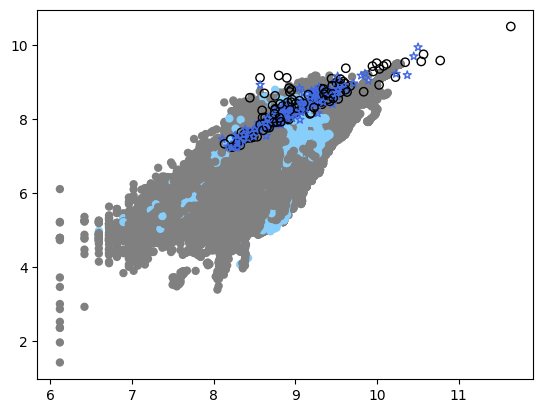

In [ ]:
# mask = first_SF[:,1]>0
# first_SF = first_SF[mask]
for i, sub in enumerate(allsubs1):
    assert sub['id'] == first_SF[i][0]
    if(first_SF[i][1]<0):
        color = 'grey' if(sub['dink']) else 'lightskyblue'
        branch = stree1[sub['id']]
        plt.scatter(np.log10(branch['mvir']), np.log10(branch['mcell_vir']), ec='none',fc=color, zorder=-1)
    else:
        marker='o' if(sub['dink']) else '*'
        color = 'k' if(sub['dink']) else 'royalblue'

        branch = stree1[sub['id']]
        where = np.where(branch['timestep'] == first_SF[i][1])[0][0]
        ib = branch[where]
        # plt.scatter(ib['timestep'], np.log10(ib['mcold_vir']), fc='none',ec=color, marker=marker)
        plt.scatter(np.log10(ib['mvir']), np.log10(ib['mcell_vir']), fc='none',ec=color, marker=marker)

In [ ]:
finddict1 = pklload(f"{database1}/SF/finddict.pickle")
finddict2 = pklload(f"{database2}/SF/finddict.pickle")

In [ ]:
keys1 = list(finddict1.keys())
keys1[0]
finddict1[11]

[20811, 22517]

In [ ]:
from ramses_function import *
params('d_gmc', nh)

2160.1734317960572

In [ ]:
for i in range(100):
    if(os.path.isdir(f"{database1}/SF/{i:05d}")):
        fnames = os.listdir(f"{database1}/SF/{i:05d}")
        for fname in fnames:
            newcell = pklload(f"{database1}/SF/{i:05d}/{fname}")
            if( np.max(newcell['nstar_iout'])>0 ):
                print(i,fname, np.max(newcell['rho']), np.max(newcell['nstar_iout']))
                stop()

21 0020811.pickle 206068.11056610767 8


ValueError: stop!

In [ ]:
densec = uri.Cell(dense, snap1s.get_snap(i))
from rur.sci.geometry import rss, ss
plt.scatter(densec['trgv'], ss(densec['vel']))
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim())

In [ ]:
# newcell = pklload(f"{database1}/SF/{26:05d}/{22517:07d}.pickle")
dense = newcell[newcell['dense']]
print(dense.dtype.names)
vals = [0]*10
vals[0] = trgv = dense['trgv']
vals[1] = c_s2 = dense['c_s2']
vals[2] = mach2 = dense['mach2']
vals[3] = alpha0 = dense['alpha0']
vals[4] = sigs = dense['sigs']
vals[5] = scrit = dense['scrit']
vals[6] = sfr_ff = dense['sfr_ff']
vals[7] = tstar = dense['tstar']
vals[8] = mstar = dense['mstar']
nstar_iout = dense['nstar_iout']
dt_iout = dense['dt_iout']
PoissMean_iout = dense['PoissMean_iout']
nstar_corr_iout = dense['nstar_corr_iout']
ind = nstar_iout>=1

fig, axes = plt.subplots(3,3)
for i in range(9):
    axes.flatten()[i].scatter(vals[i], nstar_iout)
    axes.flatten()[i].scatter(vals[i][ind], nstar_iout[ind])
    axes.flatten()[i].set_xscale('log')
    print(vals[i][ind])
# Small c_s2, alpha0, scrit, tstar
# Large sfr_ff

In [ ]:
dense = newcell[newcell['dense']]
print(dense.dtype.names)

In [ ]:
trgv = dense['trgv']; cs2 = dense['c_s2']
plt.scatter(trgv+cs2, dense['PoissMean_iout'])

In [ ]:
sigs = dense['sigs']
scrit = dense['scrit']
plt.scatter((sigs-scrit)/np.sqrt(2*sigs), dense['PoissMean_iout'])